<a href="https://colab.research.google.com/github/danlingzhou16/stat390/blob/Danling/Danling_390_auto_arima.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 26.1 MB/s eta 0:00:00


In [2]:
# libararies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

In [3]:
train = pd.read_csv('train_final.csv', parse_dates = ['date'])
test = pd.read_csv('test_final.csv', parse_dates = ['date'])

In [18]:
train_col_of_interest = train[['date','country_code', 'location_key_x', 'new_confirmed']]
test_col_of_interest = test[['date','country_code', 'location_key_x', 'new_confirmed']]

In [19]:
# group by countries
train_col_of_interest_gp = train_col_of_interest.groupby(['country_code','date'])
test_col_of_interest_gp = test_col_of_interest.groupby(['country_code','date'])

In [24]:
train_agg = train_col_of_interest_gp.agg('sum')
train_agg.reset_index(level = 'country_code', inplace = True)
test_agg = test_col_of_interest_gp.agg('sum')
test_agg.reset_index(level = 'country_code', inplace = True)

In [25]:
# stationary test
# this code block is adapted from by https://www.kaggle.com/code/sumi25/understand-arima-and-tune-p-d-q
# a fancy way to do the Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, window = 7, cutoff = 0.05):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)

    print(dfoutput)

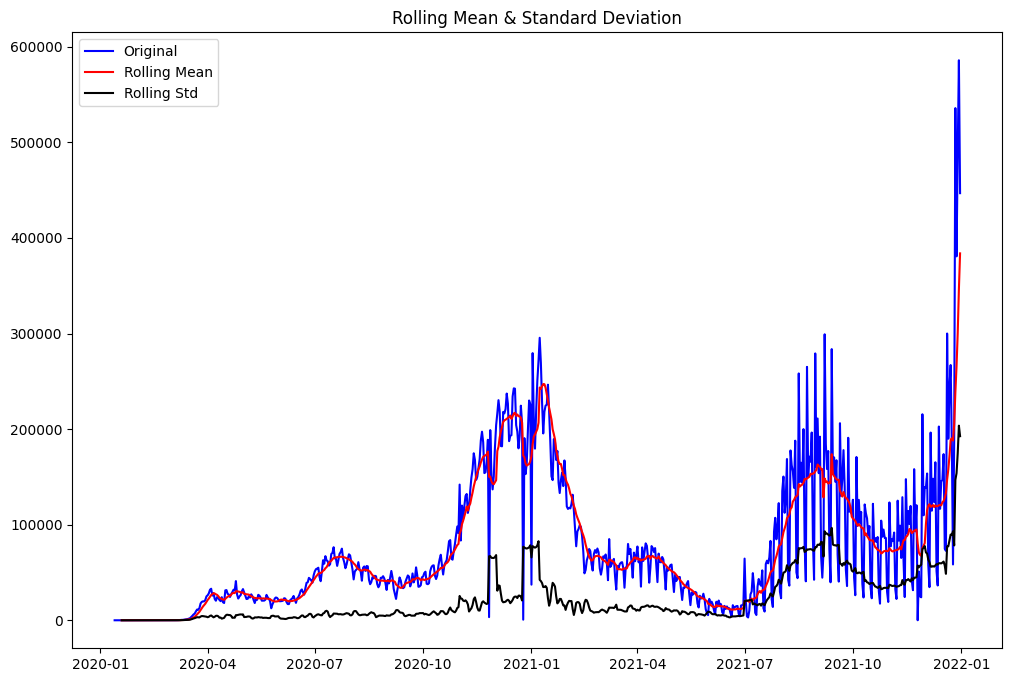

Results of Dickey-Fuller Test:
p-value = 0.9848. The series is likely non-stationary.
Test Statistic                   0.496225
p-value                          0.984758
#Lags Used                      20.000000
Number of Observations Used    698.000000
Critical Value (1%)             -3.439753
Critical Value (5%)             -2.865690
Critical Value (10%)            -2.568980
dtype: float64


In [35]:
# do the stationary test on US
train_agg_us = train_agg.loc[train_agg.country_code == 'US','new_confirmed']
test_agg_us = test_agg.loc[test_agg.country_code == 'US','new_confirmed']

test_stationarity(train_agg_us)

In [104]:
model = auto_arima(train_agg_us, start_p=1, start_q=1,
                           max_p=7, max_q=7, m=1,
                          seasonal=True,
                           d = 1, trace=True,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True, n_jobs = -1)
print(model.aic())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=17233.576, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=17476.726, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=17365.077, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=17233.289, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=17474.855, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=17233.724, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=17213.211, Time=0.22 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=17214.743, Time=0.29 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=17229.124, Time=0.19 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=17239.080, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=17221.866, Time=0.08 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=17099.963, Time=0.48 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=17092.191, Time=0.72 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=17257.401, Time=0.30 sec
 ARIMA(4,1,3)(0,0,0

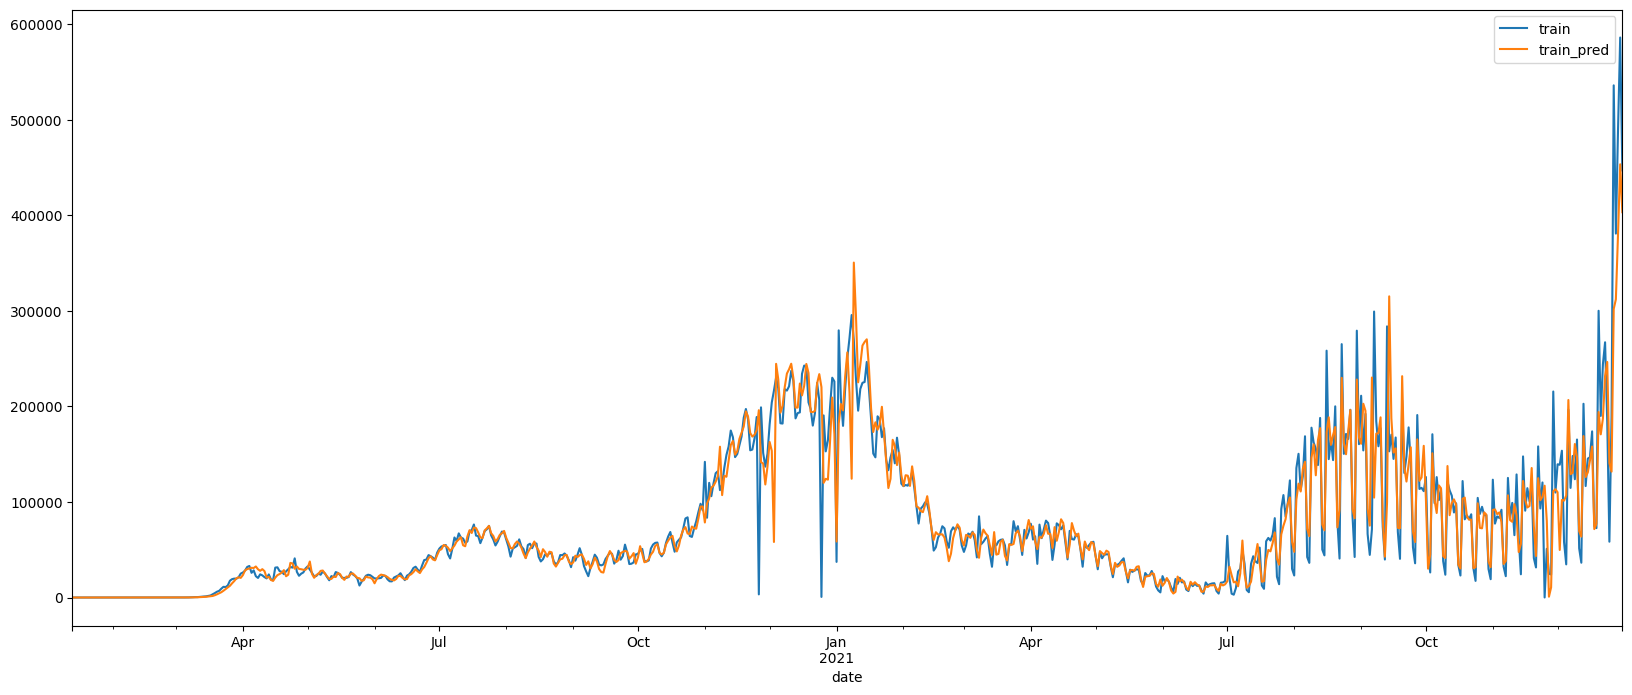

In [105]:
train_pred_us=model.fittedvalues()
pd.concat([train_agg_us, train_pred_us], axis=1).plot(figsize=(20,8))
plt.legend(['train', 'train_pred'])

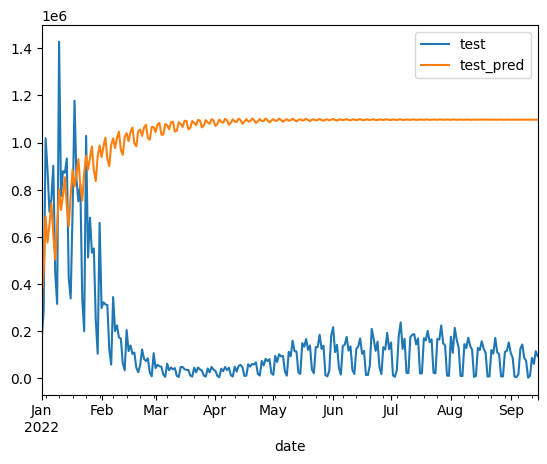

In [106]:
test_pred_us=model.predict(n_periods=len(test_agg_us))
test_pred_us.index = test_agg_us.index
pd.concat([test_agg_us, test_pred_us], axis=1).plot()

plt.legend(['test', 'test_pred'])

In [107]:
print('The rmse on the training data is ', mean_squared_error(train_agg_us, train_pred_us, squared = False))
print('The rmse on the testing data is ', mean_squared_error(test_agg_us, test_pred_us, squared = False))

The rmse on the training data is  28603.770118944944
The rmse on the testing data is  942156.649368191


Apply the model to whole 10 countries.

In [49]:
train_agg

,country_code,new_confirmed
date,,
2020-01-27,AU,0.0
2020-01-29,AU,0.0
2020-01-30,AU,0.0
2020-02-01,AU,0.0
2020-02-04,AU,0.0
...,...,...
2021-12-27,US,535815.0
2021-12-28,US,380733.0
2021-12-29,US,489474.0


In [66]:
# making datasets for storing the predicted data
train_pred = train_agg.copy()
train_pred.new_confirmed = None
train_pred.columns = ['country_code','prediected_new_confirmed']
train_pred.reset_index(inplace = True)
test_pred = test_agg.copy()
test_pred.new_confirmed = None
test_pred.columns = ['country_code','prediected_new_confirmed']
test_pred.reset_index(inplace = True)

In [109]:
loc_list = list(train_agg.country_code.unique())
for loc in loc_list:
  train_interest = train_agg.loc[train_agg.country_code == loc, 'new_confirmed'] # select the rows in the training data
  test_interest = test_agg.loc[test_agg.country_code == loc, 'new_confirmed'] # select the rows in the testing data
  # code the model
  model = auto_arima(train_interest, start_p=1, start_q=1,
                     max_p=7, max_q=7, m=1,
                     seasonal=True, d = 1,
                     error_action='ignore',
                     suppress_warnings=True,
                     stepwise=True, n_jobs = -1)
  # predict train data
  pred_for_train = model.fittedvalues()
  for date in pred_for_train.index:
    train_pred.loc[(train_pred.country_code == loc) & (train_pred.date == date), 'prediected_new_confirmed'] = pred_for_train[date]
  # predict test dataset
  pred_for_test = model.predict(n_periods=len(test_interest))
  pred_for_test.index = test_interest.index
  for date in pred_for_test.index:
    test_pred.loc[(test_pred.country_code == loc) & (test_pred.date == date), 'prediected_new_confirmed'] = pred_for_test[date]


In [110]:
print('The rmse on the training data is ', mean_squared_error(train_agg.new_confirmed, train_pred.prediected_new_confirmed, squared = False))
print('The rmse on the testing data is ', mean_squared_error(test_agg.new_confirmed, test_pred.prediected_new_confirmed, squared = False))

The rmse on the training data is  9141.24783757812
The rmse on the testing data is  302641.5017392954


now try it based on regions

In [111]:
train = pd.read_csv('train_final.csv', parse_dates = ['date'], index_col = ['date'])
test = pd.read_csv('test_final.csv', parse_dates = ['date'], index_col = ['date'])
train_sel_for_arima = train[['location_key_x', 'new_confirmed']]
test_sel_for_arima = test[['location_key_x', 'new_confirmed']]

In [112]:
# making datasets for storing the predicted data
train_pred_region = train_sel_for_arima.copy()
train_pred_region.new_confirmed = None
train_pred_region.columns = ['location_key_x','predicted_new_confirmed']
train_pred_region.reset_index(inplace = True)
test_pred_region = test_sel_for_arima.copy()
test_pred_region.new_confirmed = None
test_pred_region.columns = ['location_key_x','predicted_new_confirmed']
test_pred_region.reset_index(inplace = True)

In [113]:
loc_list = list(train_pred_region.location_key_x.unique())
for loc in loc_list:
  train_interest = train_sel_for_arima.loc[train_sel_for_arima.location_key_x == loc, 'new_confirmed'] # select the rows in the training data
  test_interest = test_sel_for_arima.loc[test_sel_for_arima.location_key_x == loc, 'new_confirmed'] # select the rows in the testing data
  # code the model
  model = auto_arima(train_interest, start_p=1, start_q=1,
                     max_p=7, max_q=7, m=1,
                     seasonal=True, d = 1,
                     error_action='ignore',
                     suppress_warnings=True,
                     stepwise=True, n_jobs = -1)
  # predict train data
  pred_for_train = model.fittedvalues()
  for date in pred_for_train.index:
    train_pred_region.loc[(train_pred_region.location_key_x == loc) & (train_pred_region.date == date), 'prediected_new_confirmed'] = pred_for_train[date]
  # predict test dataset
  pred_for_test = model.predict(n_periods=len(test_interest))
  pred_for_test.index = test_interest.index
  for date in pred_for_test.index:
    test_pred_region.loc[(test_pred_region.location_key_x == loc) & (test_pred_region.date == date), 'prediected_new_confirmed'] = pred_for_test[date]


In [114]:
print('The rmse on the training data is ', mean_squared_error(train_sel_for_arima.new_confirmed, train_pred_region.prediected_new_confirmed, squared = False))
print('The rmse on the testing data is ', mean_squared_error(test_sel_for_arima.new_confirmed, test_pred_region.prediected_new_confirmed, squared = False))

The rmse on the training data is  1144.442894539784
The rmse on the testing data is  104462.40504455385


Compared with ARIMA, this model isn't doing any better.